<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/AutoencoderBandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2pix para segmentado de imagenes NDVI


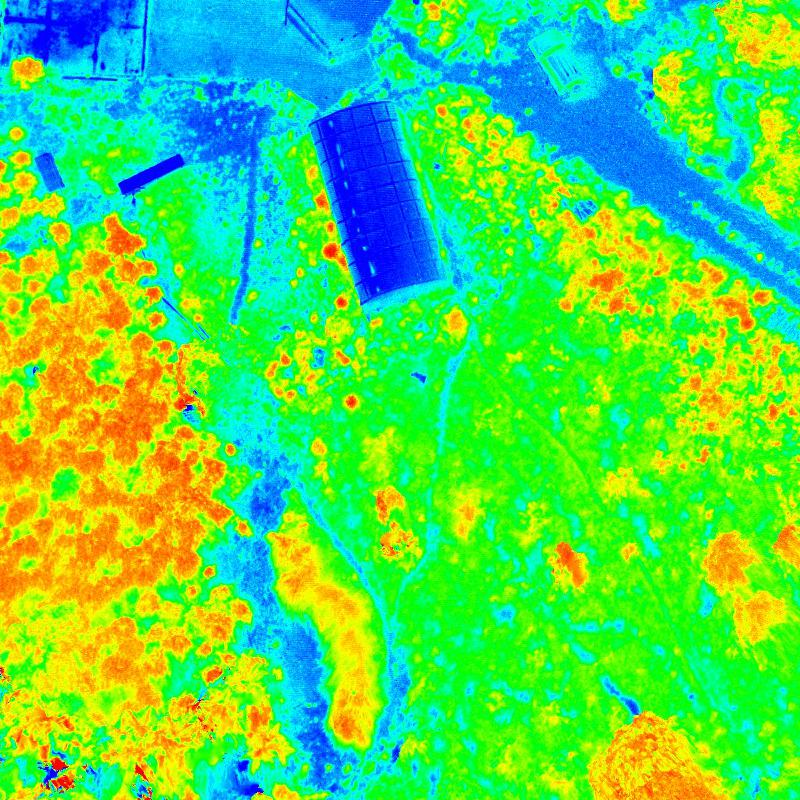



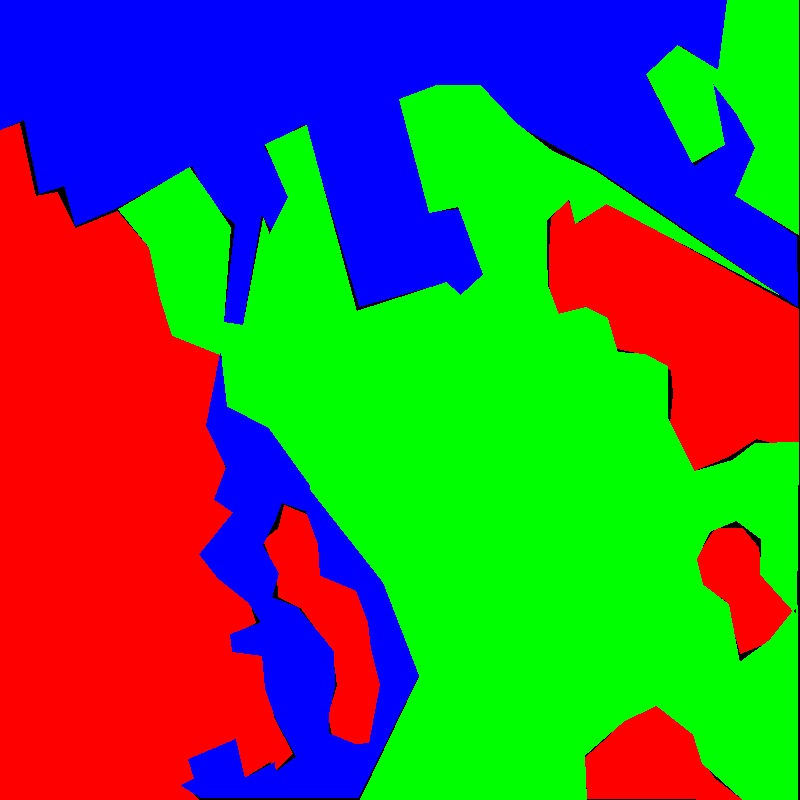{ width: 200px; }

## Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from google.colab.patches import cv2_imshow


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [2]:

# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/dataset2"

# Ruta de datos de entrada
INPATH = PATH + '/ndvi/'
# Ruta de salida
OUTPATH = PATH + '/labels/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

## Listar Archivos

In [3]:
imgurls = !ls -1 "{INPATH}"

## Particionar Dataset

In [4]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]

In [5]:
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 3210 
 Entrenamiento: 2568 
 Testeo: 642 


## Cargando imagenes

In [6]:
def leer_imagen(path):
    dim = (256,256)
    im = cv2.imread(path)
    im_r = cv2.resize(im,dim)
    return im_r

In [7]:
def load_data(urls,path):
    im_s = np.empty((1, 256,256,3))
    im_aux = np.empty((1, 256,256,3))
    cont=0
    for url in urls:
        im = leer_imagen(path + url)
        if cont == 0:
            im_s[0,...] = im
            cont +=1
        else:
            im_aux[0,...] = im
            im_s = np.append(im_s,im_aux,axis=0)
    if cont %100 ==0:
        print(cont)
    return im_s

In [8]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/255)
    tgimg = (tgimg/255)
    return inimg,tgimg

@tf.function()
# Aumentación de datos: Random Crop + Flip
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

# carga de imagenes dataset
def load_image(filename, augment=False):
    tg_name=tf.strings.regex_replace(filename, "ndvi", "label")
    b1_name=tf.strings.regex_replace(filename, "ndvi", "b1")
    b2_name=tf.strings.regex_replace(filename, "ndvi", "b2")
    b3_name=tf.strings.regex_replace(filename, "ndvi", "b3")
    b4_name=tf.strings.regex_replace(filename, "ndvi", "b4")
    banda_path = INPATH.replace('ndvi','bandas')

    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + tg_name)),tf.float32)

    b1 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b1_name)),tf.float32)[...,0:1]
    b2 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b2_name)),tf.float32)[...,0:1]
    b3 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b3_name)),tf.float32)[...,0:1]
    b4 = tf.cast(tf.image.decode_jpeg(tf.io.read_file(banda_path + '/' + b4_name)),tf.float32)[...,0:1]
    print(b1.shape)
    inimg = tf.concat([b1,b2,b3,b4],2)
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    #if augment:
        #inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

def load_train_image(filename):
    return load_image(filename,True)

def load_test_image(filename):
    return load_image(filename,False)

(None, None, None)
(None, None, None)


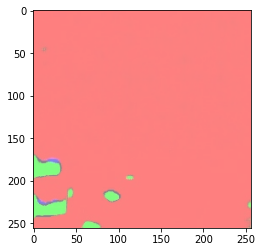

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(1):
    # plt.subplot(121)
    # plt.imshow(np.squeeze(inimg)+1/2)
    # plt.subplot(122)
    plt.imshow((np.squeeze(tgimg[0,...])+1)/2)
    plt.show()

## Creación de modelo Autoencoder

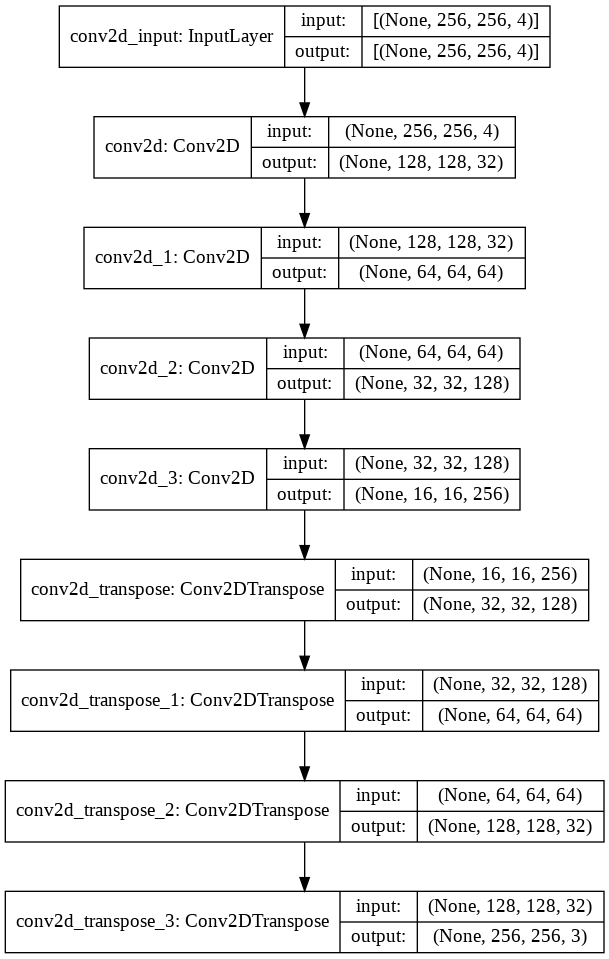

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, 
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu', input_shape=(256, 256, 4)))
model.add(layers.Conv2D(64, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(128, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(256, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2DTranspose(128,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(64,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(32,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(3,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='softmax',
                    use_bias = False))
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
history=model.fit(train_dataset,
                epochs=100,
                batch_size=16,
                validation_data=test_dataset,
                shuffle=True)

Epoch 1/100
2568/2568 [==============================] - 2055s 800ms/step - loss: 0.2900 - val_loss: 0.4761
Epoch 2/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2302 - val_loss: 0.3902
Epoch 3/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2220 - val_loss: 0.3990
Epoch 4/100
2568/2568 [==============================] - 40s 15ms/step - loss: 0.2171 - val_loss: 0.4531
Epoch 5/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2107 - val_loss: 0.4180
Epoch 6/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2084 - val_loss: 0.4258
Epoch 7/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2053 - val_loss: 0.4050
Epoch 8/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2030 - val_loss: 0.3983
Epoch 9/100
2568/2568 [==============================] - 39s 15ms/step - loss: 0.2017 - val_loss: 0.4077
Epoch 10/100
2568/2568 [============================

In [13]:
model.save('/content/drive/MyDrive/autoencodermodelbandas20211105-30.h5')

In [14]:
# imagen = 25
# plt.figure(figsize=(15,15))
# plt.subplot(131)
# plt.title('Entrada')
# plt.imshow(x_test[imagen,...])
# plt.subplot(132)
# plt.title('Etiqueta')
# plt.imshow(y_test[imagen,...])
# plt.subplot(133)
# plt.title('Predicted')
# plt.imshow(model.predict(x_test[imagen:imagen+1,...])[0,...])
# plt.show()